In [66]:
import scipy
import scipy.io as spio
import matplotlib.pyplot as plt

def loadmat(filename):
    '''
    this function should be called instead of direct spio.loadmat
    as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries
    which are still mat-objects
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = scipy.io.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [67]:
A_mat_file = loadmat('geneNetwork_rawPCNCI.mat')

In [68]:
# This is the adjacency matrix
A = A_mat_file['geneNetwork_rawPCNCI']
A.shape

(2458, 2458)

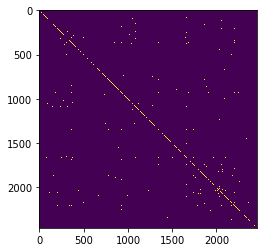

In [74]:
plt.imshow(A)

In [81]:
A

array([[1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [71]:
from copy import deepcopy

In [72]:
A_modified = deepcopy(A)
np.fill_diagonal(A_modified, 0)

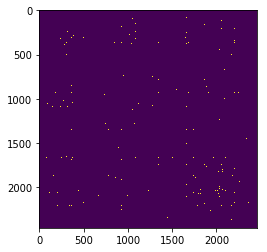

In [73]:
plt.imshow(A_modified)

# It is pretty evident from the almost unbroken straight line on the diagonal, that this matrix contains self-loops. Removing these self-loops in the next cell

In [75]:
assert(A.all() == np.transpose(A.all()))

# A = A_transpose. The adjacency matrix is symmetric, indicating an undirected graph

In [76]:
def construct_degree_matrix(adj_matrix):
    D = np.zeros((adj_matrix.shape[0], adj_matrix.shape[1]))
    for row in range(adj_matrix.shape[0]):
        D[row][row] = np.sum(adj_matrix[row,:])
    return D

In [77]:
D = construct_degree_matrix(A)

In [78]:
def construct_laplacian_matrix(adj_matrix, degree_matrix):
    return degree_matrix-adj_matrix

In [79]:
L = construct_laplacian_matrix(A, D)

In [85]:
D_modified = construct_degree_matrix(A_modified)
L_modified = construct_laplacian_matrix(A_modified, D_modified)

In [91]:
assert(L.all() == L_modified.all())

# The Laplacian is not different if the adjacency matrix is modified by removing self loops. 
# Removing a self loop indicates that the diagonal is being set to zero in the modified adjacency matrix. This also reduces the degree matrix by the same number. Thus, D-A will be the same

In [92]:
# Define the graph shift operator

In [94]:
S = L

In [99]:
# Eigendecompose the shift matrix to get the graph eigenvectors and the graph frequencies
lambda_values, V = np.linalg.eig(L)


# L's eigendecomposition gives L = VlambdaV_H
# The total variation for the kth eigenvector is defined as TV(v_k) = (v_k)^HL(v_k) = lambda_k


In [111]:
def sort_frequencies(eigenvector, lambda_values):
    # Sort the eigenvalues in ascending order
    idx = lambda_values.argsort()[::-1]   
    eigenValues = lambda_values[idx]
    eigenVectors = eigenvector[:,idx]
    
    return (eigenValues, eigenVectors)

In [112]:
evalues, evectors = sort_frequencies(V, lambda_values)

In [133]:
def compute_total_variation(evector):
    return np.dot(np.dot(evector.transpose(),L),evector)

In [134]:
TV_ = np.zeros((evectors.shape[0],1))
for column_id in range(evectors.shape[0]):
    TV_[column_id] = compute_total_variation(evectors[:, column_id])

/home/raghuram/Desktop/radiomics_venv/lib/python3.7/site-packages/ipykernel_launcher.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  This is separate from the ipykernel package so we can avoid doing imports until


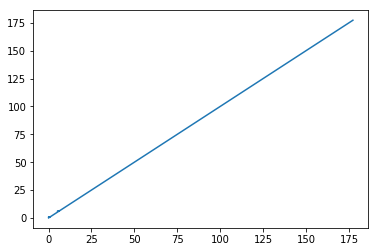

In [135]:
plt.plot(np.real(TV_), np.real(evalues))

In [136]:
X_mat = loadmat('signal_mutation.mat')

In [138]:
X = X_mat['signal_mutation']

In [167]:
X = X.T

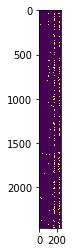

In [168]:
plt.imshow(X)

In [142]:
y_mat = loadmat('histology_subtype.mat')
y = y_mat['histology_subtype']

In [171]:
def compute_gft(V, X):
    return np.dot(V.T,X)

In [226]:
x_graph = compute_gft(evectors, X)

In [227]:
x_graph.shape

(2458, 240)

In [228]:
x_graph

array([[ 8.78618258e-02+0.j,  2.18903085e-02+0.j,  4.78337632e-02+0.j,
        ...,  9.34247228e-02+0.j,  1.00841541e-01+0.j,
         1.06266767e-01+0.j],
       [ 7.57426447e-03+0.j,  4.75612762e-02+0.j,  3.80940855e-02+0.j,
        ..., -3.57732104e-03+0.j, -8.91839160e-03+0.j,
         1.07107213e-02+0.j],
       [-9.92329273e-01+0.j,  3.64505315e-02+0.j,  6.11131791e-02+0.j,
        ..., -9.85940203e-01+0.j, -9.85203871e-01+0.j,
        -9.91008925e-01+0.j],
       ...,
       [ 4.16164069e-06+0.j, -5.93597793e-03+0.j, -6.94424306e-01+0.j,
        ...,  8.03471728e-05+0.j,  2.67534045e-06+0.j,
         7.13424119e-06+0.j],
       [ 2.83327919e-02+0.j,  2.32705689e-01+0.j,  1.55842017e-01+0.j,
        ...,  7.54761766e-01+0.j,  1.82139377e-02+0.j,
         4.85705005e-02+0.j],
       [-6.75537257e-02+0.j, -5.54860589e-01+0.j, -3.71564286e-01+0.j,
        ..., -9.24509648e-02+0.j, -4.34273951e-02+0.j,
        -1.15806387e-01+0.j]])

In [316]:
def calc_graph_freq_contribution(graph_freq_matrix, graph_freq, y, y_val_indicator):
    idx = np.where(y == y_val_indicator)    
    return np.sum(np.real(graph_freq_matrix[graph_freq][idx]))/len(idx)

In [317]:
def calc_difference_in_graph_freq_contribution(value1, value2):
    return np.abs(value1-value2)


In [337]:
def calculate_distinguishing_power(X_graph):
    DP = np.zeros((X_graph.shape[0]))
    denominator = np.sum(np.abs(X_graph), axis=1)
    for frequency in range(len(DP)):
        y1_ = calc_graph_freq_contribution(X_graph, frequency,  y, 1)
        y2_ = calc_graph_freq_contribution(X_graph, frequency,  y, 2)
        DP[frequency] = (np.abs(y1_-y2_)/denominator[frequency])
    return DP

In [335]:
DP = calculate_distinguishing_power(x_graph)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f0b9db11be0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f0b9dae69e8>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f0b990a3c88>],
 'medians': [<matplotlib.lines.Line2D at 0x7f0b89ea1518>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f0b89ea14a8>],
 'means': []}

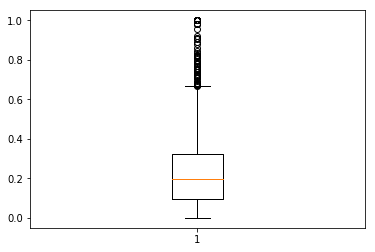

In [341]:
plt.boxplot(DP, )

<StemContainer object of 3 artists>

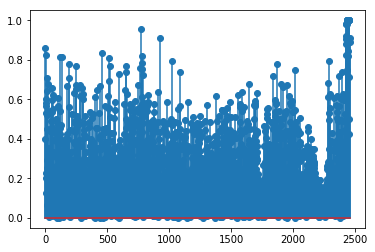

In [343]:
plt.stem(DP)